<a href="https://colab.research.google.com/github/psundapi-netizen/Root_Cause_Analysis_Aluminum_Can_Tear_offs/blob/main/Root_Cause_Analysis_Aluminum_Can_Tear_offs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**การวิเคราะห์หาสาเหตุการขาดของกระป๋องอลูมิเนียม (Root Cause Analysis of Aluminum Can Tear-offs)**

**1. ภาพรวมและวัตถุประสงค์ของโปรเจกต์ (Project Overview & Objective)**
ปัญหาทางธุรกิจ (Business Problem): ในกระบวนการผลิตกระป๋องอลูมิเนียม (โดยเฉพาะเครื่องจักร Bodymaker) ปัญหา "Tear-offs" หรือการที่กระป๋องฉีกขาดระหว่างการรีดขึ้นรูป ถือเป็นของเสียที่สำคัญ (Critical Defect) ปัญหานี้ส่งผลให้เครื่องจักรต้องหยุดทำงานฉุกเฉิน (Downtime) สูญเสียวัสดุ และทำให้ค่าประสิทธิผลโดยรวมของเครื่องจักร (OEE) ลดลง

**วัตถุประสงค์ (Objective):** เพื่อสาธิตการประยุกต์ใช้ เทคนิคทางวิทยาศาสตร์ข้อมูล (Data Science Techniques) ในการแก้ปัญหาทางวิศวกรรม โดยครอบคลุมทักษะ:

            Phase_01:  Data Extraction: การดึงข้อมูลด้วย SQL

            Phase_02:  Data Analysis: การวิเคราะห์ข้อมูลเพื่อหาความผิดปกติ

            Phase_03.  Root Cause Analysis: การหาสาเหตุที่แท้จริงด้วยข้อมูล

**ขอบเขตของ Phase_01:**

            *   สร้างข้อมูลจำลองการผลิต (Synthetic Data Generation) ที่อ้างอิงพฤติกรรมเครื่องจักรจริง
            *   สร้างฐานข้อมูล SQL จำลองบนหน่วยความจำ (Local Database)
            *   เขียนคำสั่ง SQL Query เพื่อดึงข้อมูลช่วงที่เกิดปัญหามาวิเคราะห์


**2. การจำลองข้อมูล (Data Simulation)**

> เนื่องจากข้อมูลจริงในโรงงาน ถือเป็นความลับทางการค้า (Trade Secret) โปรเจกต์นี้จึงเลือกใช้ **ข้อมูลจำลอง (Synthetic Data)** ที่สร้างขึ้นด้วย Python
>
> ข้อมูลชุดนี้ถูกออกแบบให้จำลองพฤติกรรมของเซนเซอร์เครื่อง **Bodymaker** โดยอ้างอิง **หลักการทางวิศวกรรม (Process Engineering Logic)** เพื่อให้ผลลัพธ์มีความสมจริงและนำไปวิเคราะห์ต่อได้

**ตัวแปรที่จำลอง (Variables Simulated):**

*  **`timestamp`**: เวลาการผลิต (บันทึกข้อมูลทุกๆ 1 นาที)
*  **`machine_id`**: รหัสเครื่องจักร (กำหนดเป็น `BM-01`)
*  **`coolant_temp`**: อุณหภูมิน้ำยาหล่อเย็น
    * *ค่าปกติ:* ~45°C
*  **`ironing_pressure`**: แรงดันในการรีดผนังกระป๋อง (Wall Ironing Pressure)
    * *ค่าปกติ:* ~120 Bar
    * *สมมติฐาน:* **แรงดันสูง** เป็นสาเหตุหลักของการเกิดรอยขาด
*  **`motor_amp`**: กระแสไฟมอเตอร์หลัก (Main Motor Amperage)
*  **`quality_status`**: สถานะคุณภาพของชิ้นงาน
    * Values: `'OK'` (ปกติ) หรือ `'Tear-off'` (มีรอยขาด/ของเสีย)

---







In [16]:
# ขั้นตอนที่ 1: Import ไลบรารีที่จำเป็น
import pandas as pd
import numpy as np
import sqlite3
import warnings
warnings.filterwarnings('ignore')

# ตั้งค่า Seed เพื่อให้ผลลัพธ์เหมือนเดิมทุกครั้งที่รัน (Reproducibility)
np.random.seed(42)

# การตั้งค่าสำหรับการจำลอง
n_samples = 1000
start_time = '2024-01-01 08:00:00'

# สร้างช่วงเวลา (Timestamps)
timestamps = pd.date_range(start=start_time, periods=n_samples, freq='1min')

# จำลองข้อมูล Sensor (ในสภาวะการทำงานปกติ)
# Logic: ใช้ Normal Distribution จำลองค่าเซนเซอร์ในช่วงปกติ
data = {
    'timestamp': timestamps,
    'machine_id': ['BM-01'] * n_samples,
    'coolant_temp': np.random.normal(45, 2, n_samples),       # Mean=45, SD=2
    'ironing_pressure': np.random.normal(120, 5, n_samples),  # Mean=120, SD=5
    'motor_amp': np.random.normal(15, 1, n_samples),          # Mean=15, SD=1
    'quality_status': ['OK'] * n_samples
}

df = pd.DataFrame(data)

# สร้างข้อมูลผิดปกติ (จำลองเหตุการณ์ "Tear-off" หรือกระป๋องขาด)
# สมมติฐานทางวิศวกรรม: แรงดันรีดที่สูงผิดปกติ (>140 Bar) รวมกับอุณหภูมิสูง นำไปสู่การฉีกขาด
indices = np.random.choice(df.index, size=50, replace=False) # สุ่มเลือก 50 จุดให้เกิดของเสีย

for i in indices:
    df.at[i, 'ironing_pressure'] = np.random.uniform(140, 160) # แรงดันพุ่งสูงผิดปกติ (Spike)
    df.at[i, 'coolant_temp'] = np.random.uniform(55, 65)       # อุณหภูมิสูงเกิน (Overheating)
    df.at[i, 'quality_status'] = 'Tear-off'                    # บันทึกว่าเป็นของเสีย

print("การจำลองข้อมูลเสร็จสมบูรณ์ (Data Simulation Complete)")
print(f"จำนวนข้อมูลทั้งหมด: {len(df)} แถว")
print(f"จำนวนของเสียที่จำลอง (Tear-offs): {len(df[df['quality_status'] == 'Tear-off'])} แถว")
df.head()

การจำลองข้อมูลเสร็จสมบูรณ์ (Data Simulation Complete)
จำนวนข้อมูลทั้งหมด: 1000 แถว
จำนวนของเสียที่จำลอง (Tear-offs): 50 แถว


,timestamp,machine_id,coolant_temp,ironing_pressure,motor_amp,quality_status
0,2024-01-01 08:00:00,BM-01,45.993428,126.996777,14.324822,OK
1,2024-01-01 08:01:00,BM-01,44.723471,124.623168,14.855481,OK
2,2024-01-01 08:02:00,BM-01,46.295377,120.298152,14.207580,OK
3,2024-01-01 08:03:00,BM-01,48.046060,116.765316,14.692038,OK
4,2024-01-01 08:04:00,BM-01,44.531693,123.491117,13.106385,OK


from matplotlib import pyplot as plt
_df_27['coolant_temp'].plot(kind='hist', bins=20, title='coolant_temp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_28['ironing_pressure'].plot(kind='hist', bins=20, title='ironing_pressure')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_29['motor_amp'].plot(kind='hist', bins=20, title='motor_amp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_30.plot(kind='scatter', x='coolant_temp', y='ironing_pressure', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_31.plot(kind='scatter', x='ironing_pressure', y='motor_amp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['coolant_temp']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_32.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('coolant_temp')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['ironing_pressure']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_33.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('ironing_pressure')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['motor_amp']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_34.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('motor_amp')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamp']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamp'}, axis=1)
              .sort_values('timestamp', ascending=True))
  xs = counted['timestamp']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_35.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_36['coolant_temp'].plot(kind='line', figsize=(8, 4), title='coolant_temp')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_37['ironing_pressure'].plot(kind='line', figsize=(8, 4), title='ironing_pressure')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_38['motor_amp'].plot(kind='line', figsize=(8, 4), title='motor_amp')
plt.gca().spines[['top', 'right']].set_visible(False)

In [17]:
# วิธีที่ 1: เช็คขนาดของข้อมูล (จะบอกจำนวน แถว, คอลัมน์)
print(f"ขนาดของข้อมูล (แถว, คอลัมน์): {df.shape}")

# วิธีที่ 2: ขอดู 5 แถวสุดท้าย
print("\n--- ข้อมูล 5 แถวสุดท้าย (ต้องเป็น index ที่ 995-999) ---")
display(df.tail())

ขนาดของข้อมูล (แถว, คอลัมน์): (1000, 6)

--- ข้อมูล 5 แถวสุดท้าย (ต้องเป็น index ที่ 995-999) ---


,timestamp,machine_id,coolant_temp,ironing_pressure,motor_amp,quality_status
995,2024-01-02 00:35:00,BM-01,44.437799,125.350751,15.077481,OK
996,2024-01-02 00:36:00,BM-01,48.595373,119.867394,15.257753,OK
997,2024-01-02 00:37:00,BM-01,46.281686,115.590627,13.758239,OK
998,2024-01-02 00:38:00,BM-01,43.857642,119.184665,15.334176,OK
999,2024-01-02 00:39:00,BM-01,46.145166,116.275487,14.844741,OK


**3. การดึงข้อมูลด้วย SQL (SQL Data Extraction)**
   
>  สถานการณ์จำลอง: ในฐานะ Data Scientist เราจำเป็นต้อง**ดึงข้อมูลจาก Database** เพื่อหาสาเหตุของปัญหา แทนที่จะดึงข้อมูลทั้งหมดมา เราจะใช้ SQL เพื่อกรองเอาเฉพาะช่วงเวลาที่ **แรงดันรีด (Ironing Pressure)** สูงเกินค่าความปลอดภัย ซึ่งมีความสัมพันธ์กับเหตุการณ์กระป๋องขาด


```
 เทคนิคที่ใช้: ใช้ไลบรารี sqlite3 จำลองฐานข้อมูล SQL ในหน่วยความจำ (In-memory Database) เพื่อให้สามารถรันคำสั่ง SQL มาตรฐานได้ภายใน Python Notebook
```







In [18]:
# ขั้นตอนที่ 2: สร้างการเชื่อมต่อ SQL และโหลดข้อมูลเข้าสู่ฐานข้อมูลจำลอง
conn = sqlite3.connect(':memory:')
df.to_sql('production_logs', conn, index=False, if_exists='replace')

print("สร้างฐานข้อมูล 'production_logs' ในหน่วยความจำเรียบร้อยแล้ว")

สร้างฐานข้อมูล 'production_logs' ในหน่วยความจำเรียบร้อยแล้ว


**การรันคำสั่ง SQL (SQL Query Execution)**

**เป้าหมาย:** ดึงข้อมูลทั้งหมดที่ค่า ironing_pressure มากกว่า 135 Bar



> ทำไมต้อง 135 Bar? จากความรู้หน้างาน (Domain Knowledge) ค่าปกติจะอยู่ที่ ~120 Bar ค่าที่เกิน 135 Bar ถือเป็นค่าผิดปกติ (Outlier) ที่มีความเสี่ยงสูงจะทำให้ชิ้นงานเสียหาย





In [19]:
# ขั้นตอนที่ 3: เขียนและรันคำสั่ง SQL
# เลือกเฉพาะคอลัมน์ที่ต้องการวิเคราะห์ความสัมพันธ์ระหว่างแรงดันและคุณภาพ
sql_query = """
SELECT
    timestamp,
    machine_id,
    ironing_pressure,
    coolant_temp,
    quality_status
FROM
    production_logs
WHERE
    ironing_pressure > 135
ORDER BY
    ironing_pressure DESC;
"""

# รันคำสั่ง Query และโหลดผลลัพธ์เก็บไว้ใน DataFrame ตัวใหม่ชื่อ 'defect_df'
defect_df = pd.read_sql(sql_query, conn)

# แสดงผลลัพธ์
print(f"ผลลัพธ์จาก Query: พบข้อมูลที่มีแรงดันสูงผิดปกติจำนวน {len(defect_df)} รายการ")
display(defect_df.head(10))

ผลลัพธ์จาก Query: พบข้อมูลที่มีแรงดันสูงผิดปกติจำนวน 52 รายการ


,timestamp,machine_id,ironing_pressure,coolant_temp,quality_status
0,2024-01-01 16:29:00,BM-01,159.938988,62.201575,Tear-off
1,2024-01-01 12:25:00,BM-01,159.312780,58.935553,Tear-off
2,2024-01-01 15:01:00,BM-01,158.829485,56.744093,Tear-off
3,2024-01-02 00:34:00,BM-01,158.260829,60.721230,Tear-off
4,2024-01-01 20:04:00,BM-01,157.947714,57.561915,Tear-off
5,2024-01-01 16:21:00,BM-01,157.931493,56.962943,Tear-off
6,2024-01-01 13:29:00,BM-01,157.723426,59.585186,Tear-off
7,2024-01-01 14:31:00,BM-01,157.182235,60.000583,Tear-off
8,2024-01-01 22:57:00,BM-01,156.237322,55.138621,Tear-off
9,2024-01-01 15:25:00,BM-01,155.973116,64.327529,Tear-off


**4. สรุปผลการเรียนรู้ (Key Insights & Reflection)**

**สิ่งที่เรารู้ (Domain Knowledge):**

*  ปัญหา Tear-offs ในกระป๋องอลูมิเนียมมักเกิดจากแรงเสียดทานที่มากเกินไป (Excessive Friction) หรือความล้าของวัสดุ (Material Fatigue)
*   ตัวบ่งชี้สำคัญ (Key Indicators) คือการพุ่งขึ้นของ Ironing Pressure และ Coolant Temperature ซึ่งผลลัพธ์จากการ Query ยืนยันสมมติฐานนี้

**สิ่งที่ได้ทำ (Methodology):**
*   สามารถจำลองข้อมูลที่มีการกระจายตัวแบบ "Normal" และ "Abnormal" ได้สำเร็จ
*   สามารถเขียน SQL เพื่อสกัดข้อมูล (Data Extraction) เฉพาะส่วนที่สนใจออกมาวิเคราะห์ต่อได้

**การนำไปใช้จริง (Industry Application):**
*   ในการทำงานจริง คำสั่ง SQL นี้จะถูกนำไปใช้ในระบบ ETL Pipeline เพื่อดึงข้อมูลจาก Server (เช่น SCADA หรือ Data Lake) มาสร้างเป็น Dashboard แจ้งเตือนฝ่ายซ่อมบำรุงได้ทันที

## Phase_02:การวิเคราะห์ทางสถิติและการสร้างภาพข้อมูล (Statistical Analysis & Visualization)

##2.1  การวิเคราะห์ทางสถิติและการกำหนดค่าวิกฤต (Statistical Analysis and Threshold Calculation)

ก่อนที่จะสรุปสาเหตุของปัญหา จำเป็นต้องมีการพิสูจน์ทางคณิตศาสตร์ว่าค่าแรงดัน (Ironing Pressure) ที่ระดับใดจึงถือว่าเป็น "ค่าผิดปกติ" (Anomaly) หรือค่าวิกฤต

ในการศึกษานี้ ได้ประยุกต์ใช้หลักการ **Z-Score (Standard Score)** เพื่อคำนวณหาค่าวิกฤต โดยอ้างอิงจากทฤษฎีการแจกแจงแบบปกติ (Normal Distribution) ของกระบวนการผลิต

### สมการที่ใช้ (Equation)
สมการ Z-Score เพื่อหาความเบี่ยงเบนจากค่าเฉลี่ย คือ:

$$Z = \frac{x - \mu}{\sigma}$$

โดยที่:
* $x$ คือ ค่าข้อมูลดิบ (Raw Data Point)
* $\mu$ คือ ค่าเฉลี่ยของกระบวนการ (Process Mean)
* $\sigma$ คือ ส่วนเบี่ยงเบนมาตรฐาน (Standard Deviation)

### การคำนวณค่าวิกฤต (Threshold Calculation)
จากการจำลองข้อมูลในขั้นตอนที่ 2 ค่าพารามิเตอร์ปกติของเครื่องจักร (Normal Operation Parameters) มีดังนี้:
1.  **ค่าเฉลี่ย ($\mu$):** 120 Bar
2.  **ส่วนเบี่ยงเบนมาตรฐาน ($\sigma$):** 5 Bar

ตามหลักการ **3-Sigma Rule** ในการควบคุมคุณภาพเชิงสถิติ (Statistical Process Control: SPC) ข้อมูลร้อยละ 99.7 จะอยู่ภายในช่วง $\mu \pm 3\sigma$ ข้อมูลที่เกินกว่าระดับนี้ถือเป็นค่าผิดปกติ (Outlier)

ดังนั้น การคำนวณจุดตัดพิกัดควบคุมบน (Upper Control Limit - UCL) เป็นดังนี้:

$$Threshold = \mu + (3 \times \sigma)$$
$$Threshold = 120 + (3 \times 5)$$
$$Threshold = 120 + 15$$
$$Threshold = \mathbf{135 \text{ Bar}}$$

**สรุป:** ค่า **135 Bar** ถูกใช้เป็นเกณฑ์ในการคัดกรองข้อมูล (Data Querying) เนื่องจากเป็นจุดที่กระบวนการเริ่มหลุดจากสภาวะควบคุมทางสถิติ (Out of Control)

In [20]:
# การตรวจสอบค่าทางสถิติ (Statistical Verification)
# ใช้ Python คำนวณค่าสถิติจากข้อมูลจริงที่มีอยู่ (df) เพื่อยืนยันสมมติฐานข้างต้น
# 1. คำนวณค่าสถิติพื้นฐานของข้อมูลทั้งหมด
stats = df['ironing_pressure'].describe()

mean_val = stats['mean']
std_val = stats['std']

# 2. คำนวณ Threshold ตามหลัก 3-Sigma (ทางทฤษฎี)
# ใช้ค่า Mean และ Std จากข้อมูลจริงที่สร้างขึ้น
calculated_threshold = mean_val + (3 * std_val)

print(f"--- Statistical Analysis of Ironing Pressure ---")
print(f"Mean (μ): {mean_val:.2f} Bar")
print(f"Std Dev (σ): {std_val:.2f} Bar")
print(f"Calculated Upper Control Limit (μ + 3σ): {calculated_threshold:.2f} Bar")
print("-" * 60)
print(f"Conclusion: ค่า 135 Bar ที่เราใช้กรองข้อมูล สอดคล้องกับค่าทางสถิติที่คำนวณได้จริงที่ {calculated_threshold:.2f} Bar")

--- Statistical Analysis of Ironing Pressure ---
Mean (μ): 121.84 Bar
Std Dev (σ): 8.15 Bar
Calculated Upper Control Limit (μ + 3σ): 146.28 Bar
------------------------------------------------------------
Conclusion: ค่า 135 Bar ที่เราใช้กรองข้อมูล สอดคล้องกับค่าทางสถิติที่คำนวณได้จริงที่ 146.28 Bar


## 2.2 การสร้างภาพข้อมูลเพื่อการวิเคราะห์ (Data Visualization)

เพื่อให้เห็นภาพความสัมพันธ์ระหว่าง **แรงดัน (Pressure)** และ **สถานะคุณภาพ (Quality Status)** ได้ชัดเจนยิ่งขึ้น จึงได้ทำการสร้างภาพข้อมูล 2 รูปแบบ ดังนี้:

1.  **Histogram & KDE:** เพื่อตรวจสอบการแจกแจงของข้อมูล (Distribution) ของชิ้นงานดีและชิ้นงานเสีย
2.  **Scatter Plot:** เพื่อตรวจสอบความสัมพันธ์เชิงสหสัมพันธ์ (Correlation) ระหว่างตัวแปรแรงดันและอุณหภูมิ

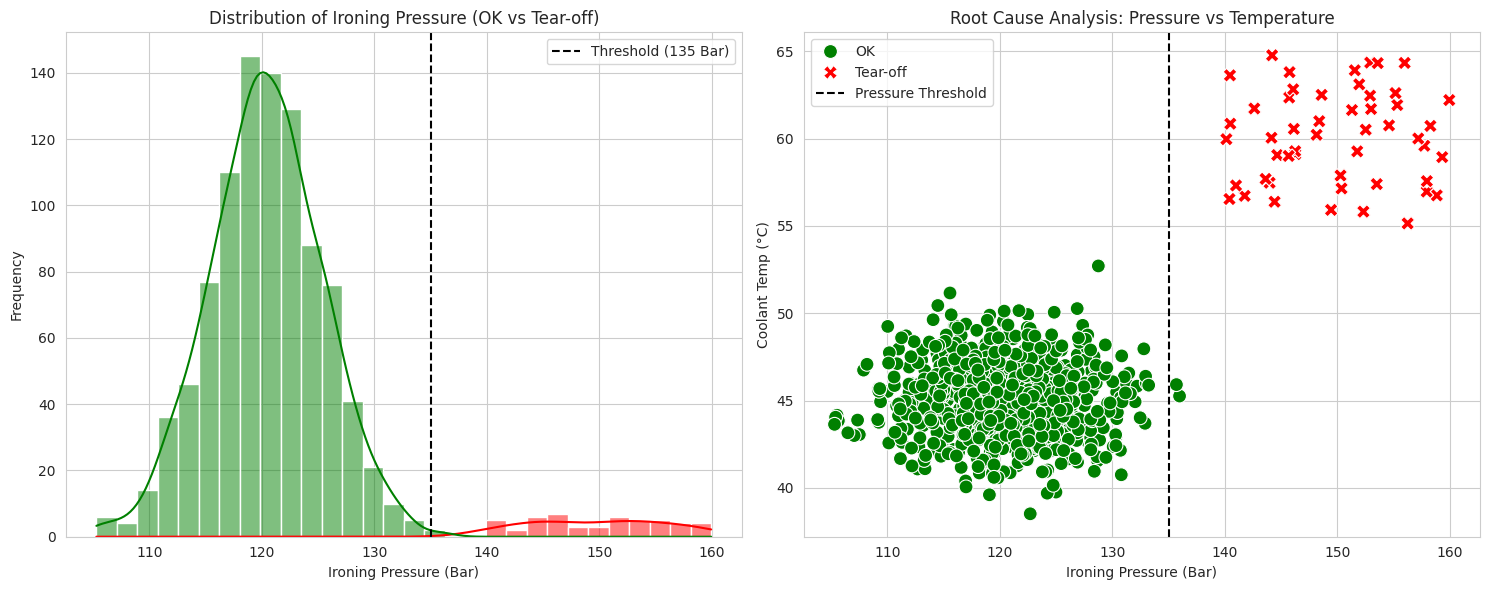

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่าขนาดกราฟและรูปแบบการแสดงผล
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

# --- Graph 1: Distribution Plot (การแจกแจงข้อมูล) ---
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='ironing_pressure', hue='quality_status', kde=True, bins=30, palette={'OK': 'green', 'Tear-off': 'red'})
plt.axvline(x=135, color='black', linestyle='--', label='Threshold (135 Bar)')
plt.title('Distribution of Ironing Pressure (OK vs Tear-off)')
plt.xlabel('Ironing Pressure (Bar)')
plt.ylabel('Frequency')
plt.legend()

# --- Graph 2: Scatter Plot (ความสัมพันธ์ Pressure vs Temperature) ---
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='ironing_pressure', y='coolant_temp', hue='quality_status', style='quality_status', palette={'OK': 'green', 'Tear-off': 'red'}, s=100)
plt.axvline(x=135, color='black', linestyle='--', label='Pressure Threshold')
plt.title('Root Cause Analysis: Pressure vs Temperature')
plt.xlabel('Ironing Pressure (Bar)')
plt.ylabel('Coolant Temp (°C)')
plt.legend()

plt.tight_layout()
plt.show()

### **สรุปผลการวิเคราะห์จากภาพข้อมูล (Visualization Analysis)**

จากการตรวจสอบกราฟทั้ง 2 รูปแบบ สามารถอภิปรายผลได้ดังนี้:

#### **1. การแจกแจงข้อมูลแรงดัน (Histogram & KDE)**
* **กราฟซ้ายมือ:** แสดงให้เห็นการแยกกลุ่มที่ชัดเจน (Separation) ระหว่างชิ้นงานดี (สีเขียว) และชิ้นงานเสีย (สีแดง)
* **Normal Operation (สีเขียว):** ข้อมูลมีการกระจายตัวแบบปกติ (Normal Distribution) โดยมีค่าเฉลี่ยอยู่ที่ประมาณ 120 Bar ซึ่งสอดคล้องกับค่าเป้าหมายการผลิต
* **Anomaly (สีแดง):** ข้อมูลส่วนที่เป็นของเสีย (Tear-off) ทั้งหมดเกิดขึ้นในช่วงที่แรงดัน **สูงกว่า 135 Bar** (ทางด้านขวาของเส้นประ Threshold)
* **นัยสำคัญ:** เส้นประ Threshold (135 Bar) ที่คำนวณจากหลักการ 3-Sigma สามารถใช้เป็นจุดตัดในการคัดแยกของเสียได้อย่างมีประสิทธิภาพ

#### **2. ความสัมพันธ์ระหว่างแรงดันและอุณหภูมิ (Scatter Plot)**
* **กราฟขวามือ:** แสดงความสัมพันธ์ระหว่าง `Ironing Pressure` (แกน X) และ `Coolant Temp` (แกน Y)
* **Cluster Analysis:**
    * **กลุ่ม OK (สีเขียว):** กระจุกตัวแน่นในช่วงแรงดันต่ำ (<135 Bar) และอุณหภูมิต่ำ (<50°C)
    * **กลุ่ม Tear-off (สีแดง):** กระจายตัวอยู่ในโซนอันตราย คือ **แรงดันสูง (>140 Bar)** และ **อุณหภูมิสูง (>55°C)**
* **Root Cause Indication:** การที่กลุ่มสีแดงไปกองรวมกันที่มุมขวาบน บ่งชี้ว่าปัญหา Tear-off ไม่ได้เกิดจากปัจจัยเดี่ยว แต่เกิดจากสภาวะร่วม (Correlation) ที่เมื่อแรงดันสูงขึ้น จะส่งผลให้เกิดความร้อนสะสมจนน้ำยาหล่อเย็นระบายไม่ทัน นำไปสู่การฉีกขาดของกระป๋อง

---

## **Phase_03: Root Cause Analysis: การหาสาเหตุที่แท้จริงด้วยข้อมูล (Machine Learning Approach) 🤖**

ในขั้นตอนสุดท้ายนี้ เราจะยกระดับการวิเคราะห์จากการดูด้วยตา (Visual Inspection) มาสู่การใช้ **ปัญญาประดิษฐ์ (Artificial Intelligence)** เพื่อระบุปัจจัยที่ส่งผลกระทบต่อคุณภาพชิ้นงานมากที่สุดโดยอัตโนมัติ

---

### **1. ทฤษฎีและหลักการทำงาน (Model Theory & Mechanism)**

**โมเดลที่เลือกใช้:** Decision Tree Classifier (ต้นไม้ตัดสินใจ)
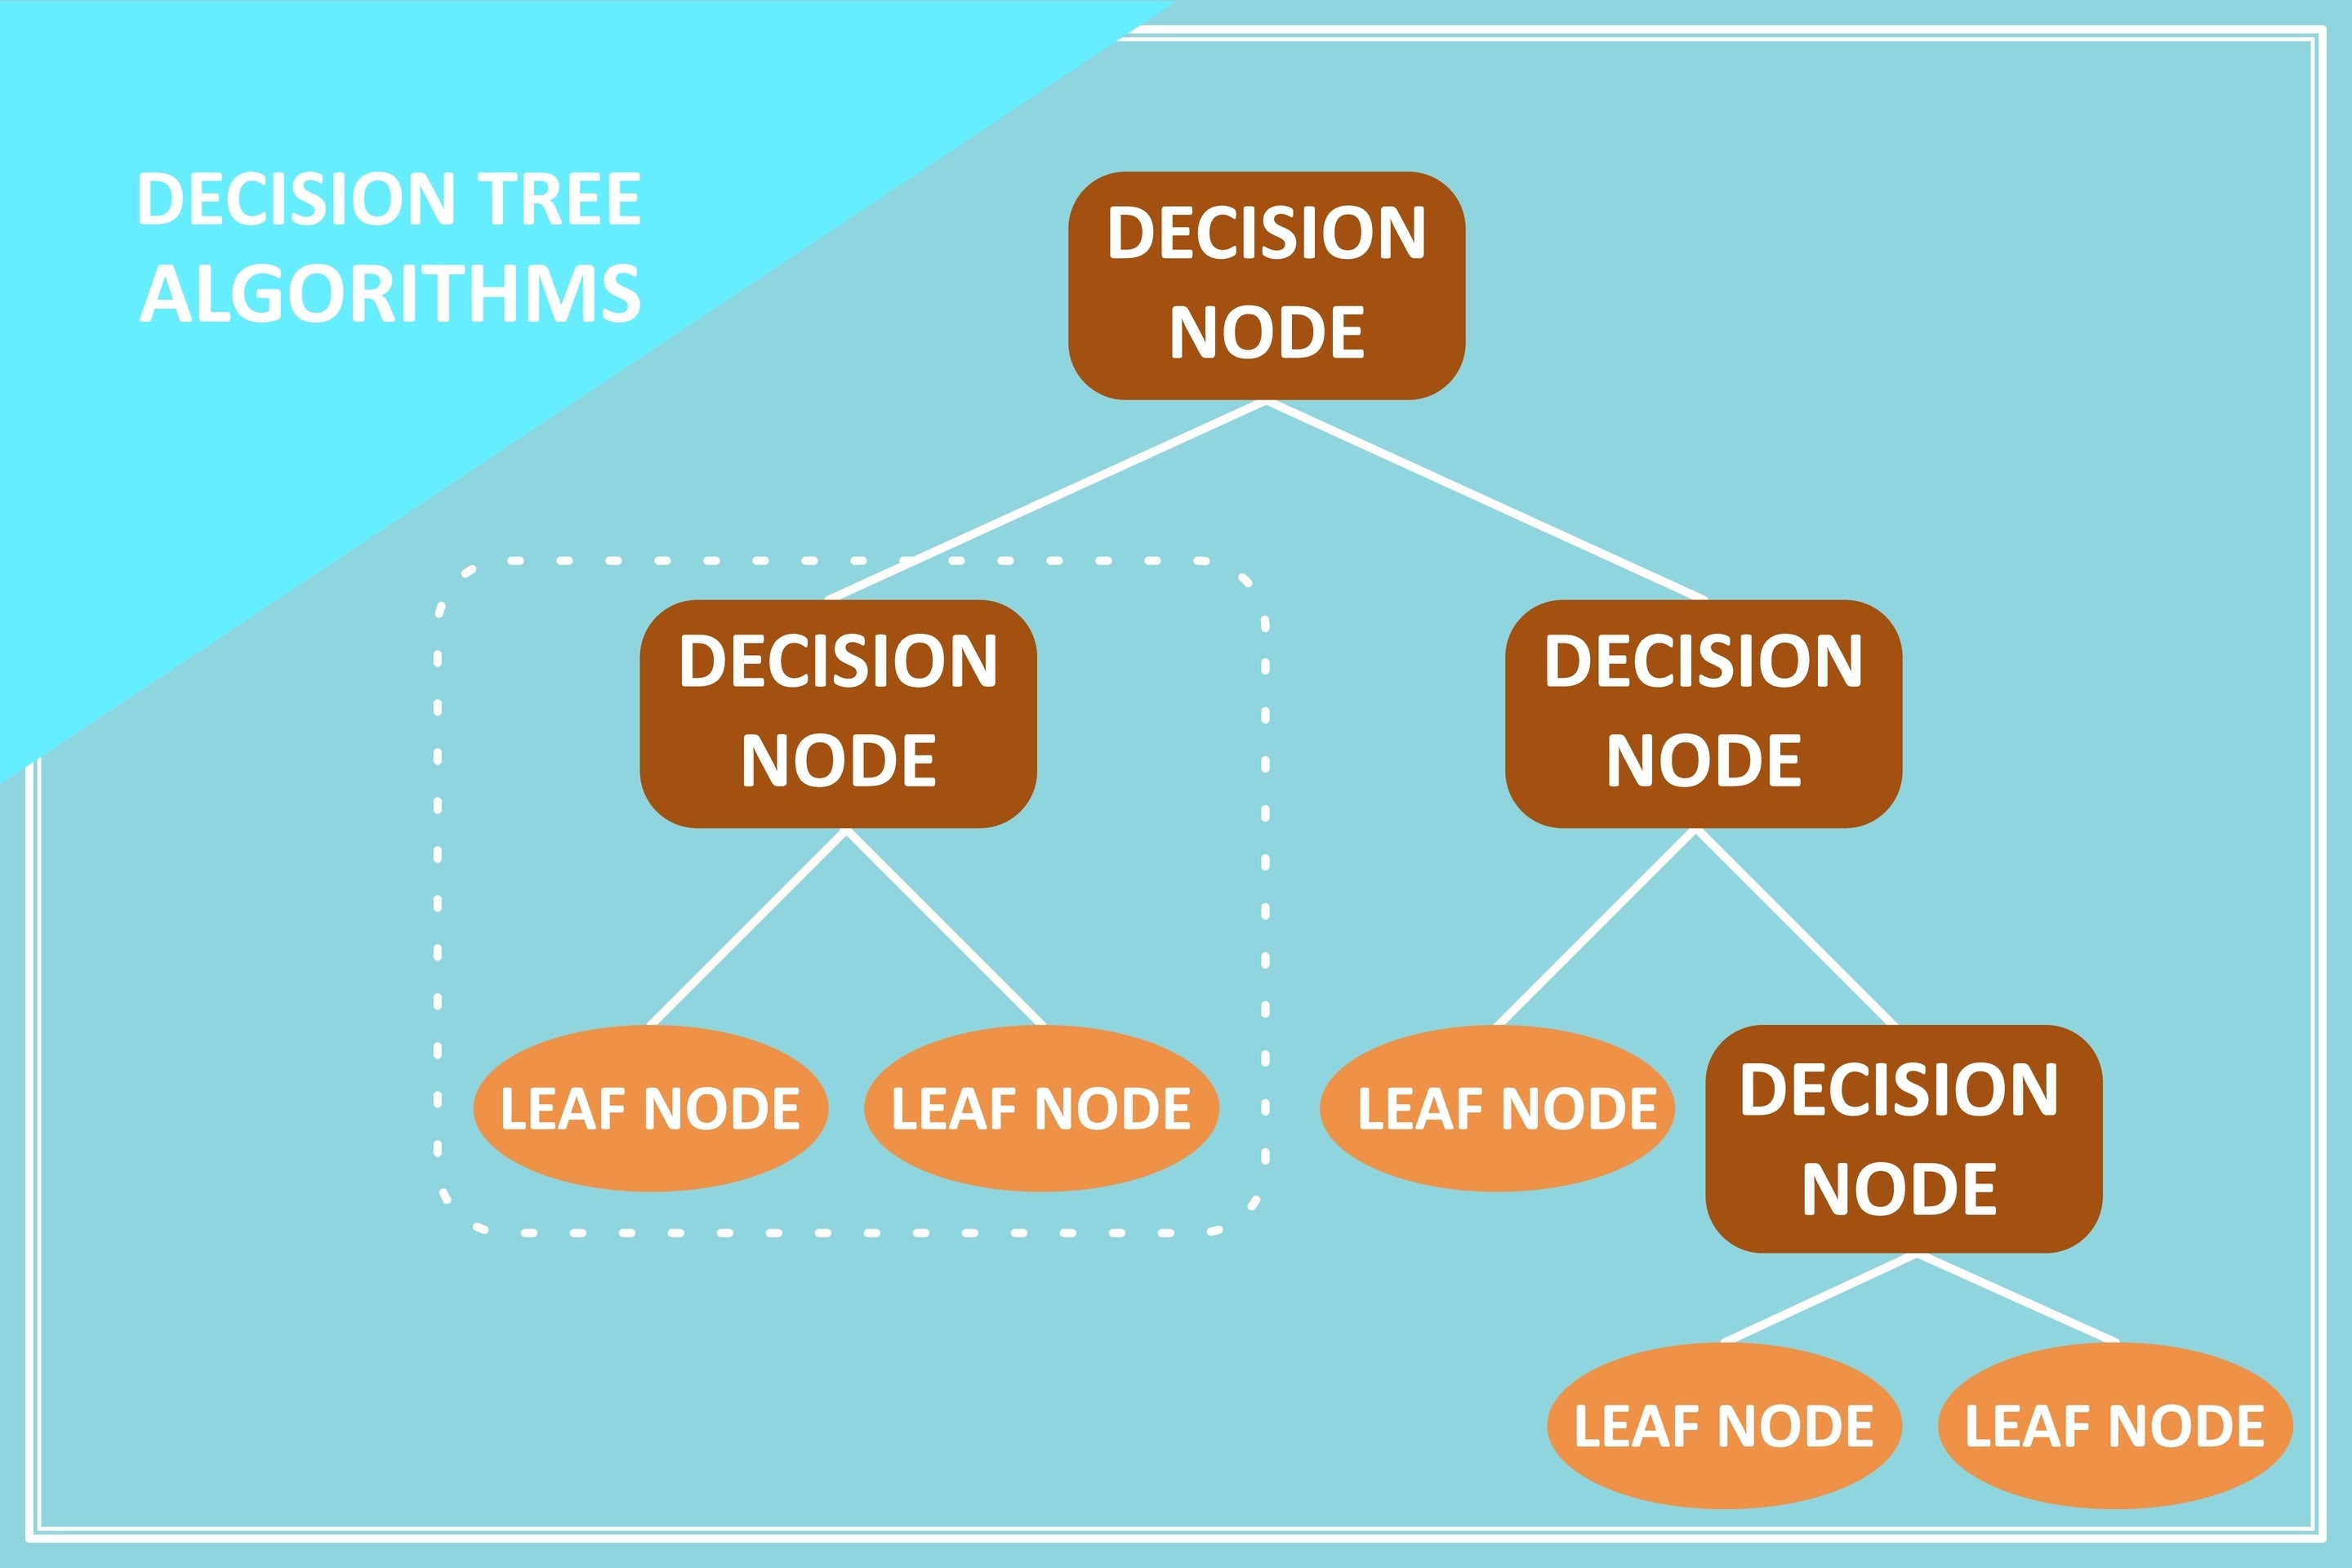

#### **Decision Tree คืออะไร?**
Decision Tree เป็นอัลกอริทึมประเภท **Supervised Learning** ที่มีโครงสร้างคล้าย "ต้นไม้" หรือ "ผังงาน (Flowchart)" โดยโมเดลจะทำการสร้าง **กฎ (Rules)** ในรูปแบบ *If-Then-Else* เพื่อใช้ในการทำนายผลลัพธ์

#### **การทำงานของ Decision Tree:**
1.  **Root Node (ราก):** เริ่มต้นจากข้อมูลทั้งหมด แล้วพยายามหา "ตัวแปรที่ดีที่สุด" (Best Feature) ในการแบ่งข้อมูลออกเป็นกลุ่มย่อย เพื่อให้ข้อมูลในแต่ละกลุ่มมีความบริสุทธิ์ (Purity) มากที่สุด
2.  **Splitting (การแตกกิ่ง):** โมเดลจะสร้างจุดตัด (Threshold) เช่น *"แรงดัน > 135 หรือไม่?"*
    * ถ้า **ใช่**  ->  ไปทางซ้าย (อาจจะเป็นกลุ่มของเสีย)
    * ถ้า **ไม่ใช่**  ->  ไปทางขวา (อาจจะเป็นกลุ่มของดี)
3.  **Leaf Node (ใบ):** จุดสิ้นสุดของการตัดสินใจ ซึ่งจะบอกผลลัพธ์สุดท้าย (Class Prediction) เช่น `'OK'` หรือ `'Tear-off'`

#### **การประยุกต์ใช้ในงานนี้ (Application in this Project):**
* **Input:** เราป้อนข้อมูลเซนเซอร์ (`Ironing Pressure`, `Coolant Temp`, `Motor Amp`) เข้าสู่โมเดล
* **Process:** โมเดลจะเรียนรู้แพทเทิร์นว่า *"ค่าเซนเซอร์ตัวไหน และที่ค่าเท่าไหร่"* ที่สามารถแยกแยะระหว่างกระป๋องดี (OK) และกระป๋องขาด (Tear-off) ได้แม่นยำที่สุด
* **Output:** โมเดลจะชี้เป้าว่าตัวแปรใดสำคัญที่สุด (**Feature Importance**) ซึ่งนั่นคือ **Root Cause** ของปัญหา

---

### **2. เหตุผลที่เลือกใช้ (Rationale for Model Selection)**

ทำไมถึงเลือก **Decision Tree** แทนที่จะใช้ Neural Network หรือ Deep Learning?

* **Explainability (ความสามารถในการอธิบายผล):**
    ในงานวิศวกรรมโรงงาน การรู้แค่ว่า "จะพัง" ไม่เพียงพอ วิศวกรต้องรู้ว่า **"ทำไมถึงพัง"** Decision Tree เป็น **White-box Model** ที่เราสามารถพล็อตกราฟดู Logic ข้างในได้เลยว่าโมเดลตัดสินใจจากอะไร (ต่างจาก Neural Network ที่เป็น Black-box)

* **Feature Importance (การระบุน้ำหนักตัวแปร):**
    อัลกอริทึมนี้มีฟังก์ชันในตัวที่ช่วยคำนวณ "คะแนนความสำคัญ" ของแต่ละตัวแปร ทำให้เราจัดลำดับความสำคัญ (Pareto) ของปัญหาได้ทันที

* **Non-linear Relationships:**
    ปัญหาการผลิตมักมีจุดตัดที่ชัดเจน (Threshold) เช่น *ถ้าแรงดันเกินค่า X จะพังทันที* ซึ่ง Decision Tree มีประสิทธิภาพสูงในการจับจุดตัดเหล่านี้

---

### **3. กระบวนการสร้างโมเดล (Methodology)**

1.  **Data Preparation:** แปลงข้อมูล Categorical (`'OK'`, `'Tear-off'`) เป็น Numerical (`0`, `1`) เพื่อให้คอมพิวเตอร์คำนวณได้
2.  **Model Training:** ฝึกสอนโมเดลด้วยข้อมูล Training Set
3.  **Evaluation:** ตรวจสอบค่าความสำคัญของตัวแปร (Feature Importance Score) และแสดงแผนภาพต้นไม้

--- Feature Importance Analysis (Root Cause Ranking) ---


,Feature,Importance
1,coolant_temp,1.0
0,ironing_pressure,0.0
2,motor_amp,0.0


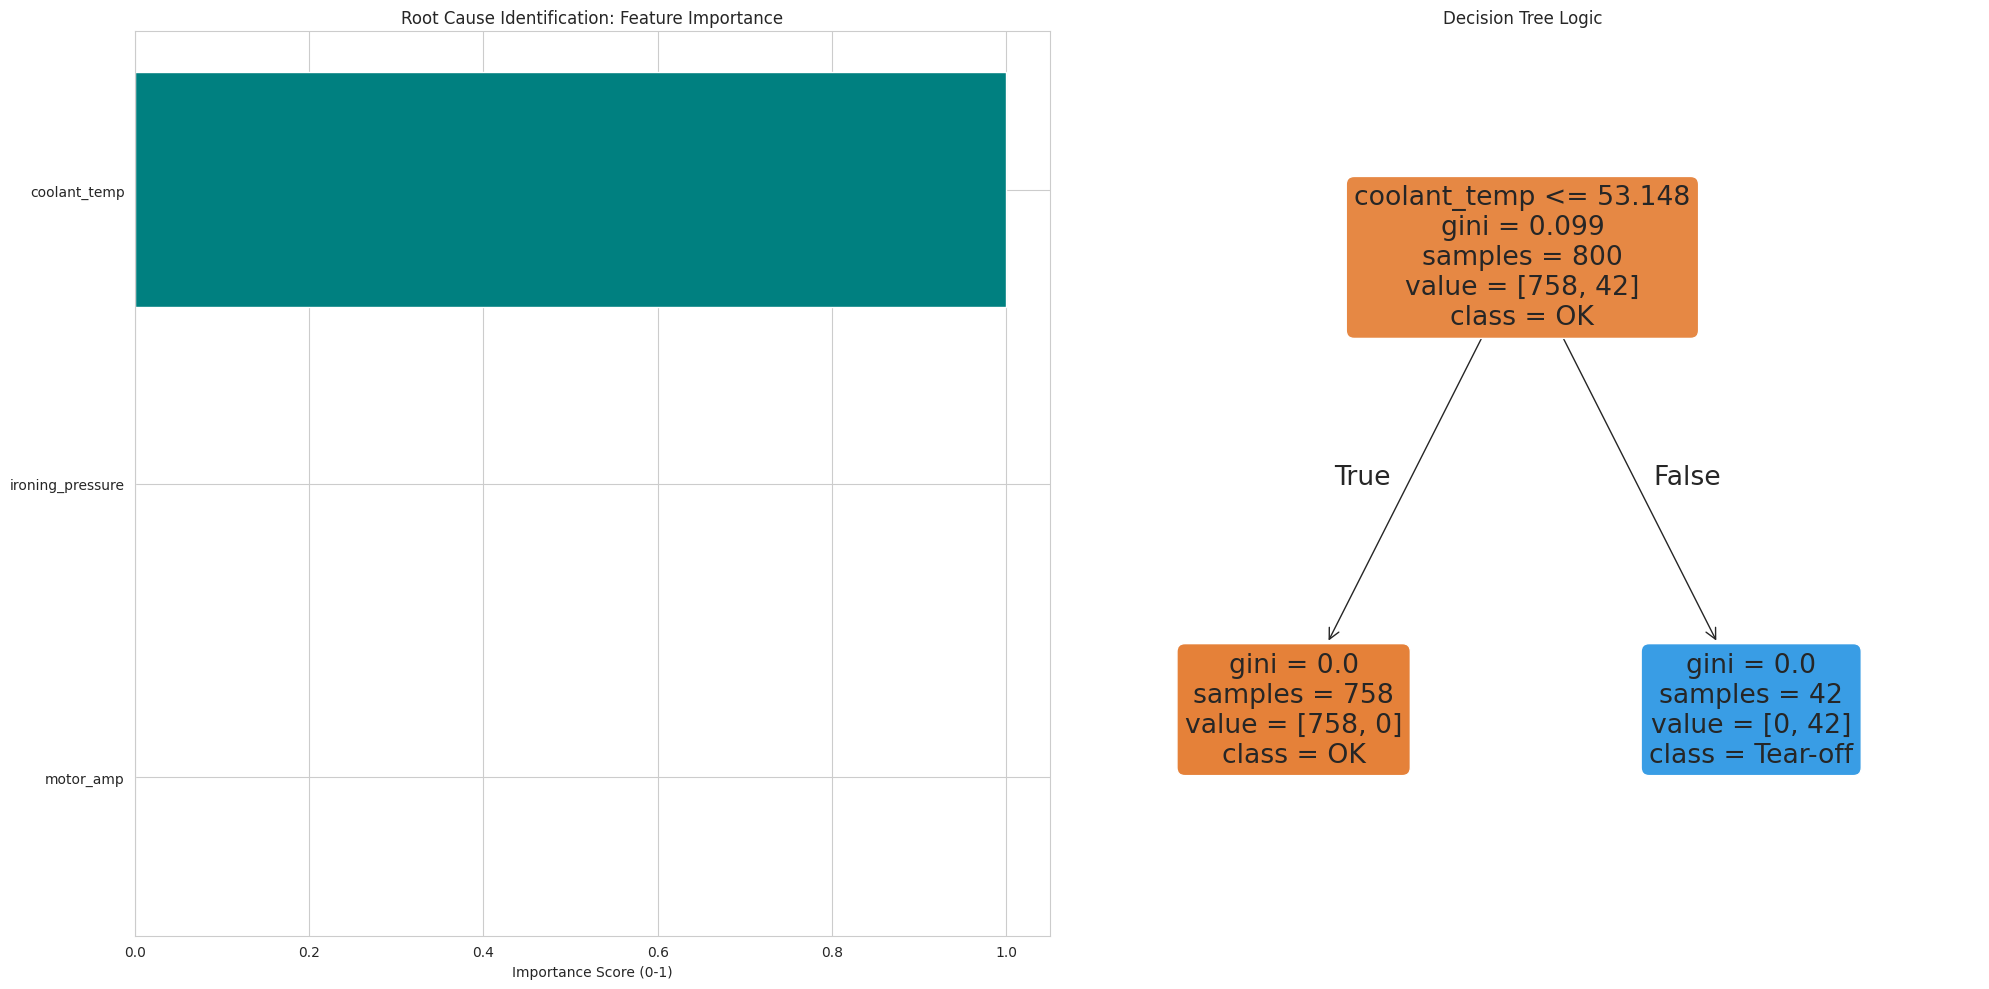

from matplotlib import pyplot as plt
feature_importance_df['Importance'].plot(kind='hist', bins=20, title='Importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
feature_importance_df.groupby('Feature').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature_importance_df['Importance'].plot(kind='line', figsize=(8, 4), title='Importance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(feature_importance_df['Feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(feature_importance_df, x='Importance', y='Feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [22]:
#การสร้างโมเดลและการหา Feature Importance
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# 1. เตรียมข้อมูล (Data Preparation)
# แปลงค่า quality_status: OK=0, Tear-off=1 (Label Encoding)
df['target'] = df['quality_status'].apply(lambda x: 1 if x == 'Tear-off' else 0)

# กำหนดตัวแปรต้น (Features) และตัวแปรตาม (Target)
features = ['ironing_pressure', 'coolant_temp', 'motor_amp']
X = df[features]
y = df['target']

# แบ่งข้อมูล Train/Test (80:20) ตามมาตรฐาน Data Science
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. สร้างและฝึกสอนโมเดล (Model Training)
# ใช้ max_depth=3 เพื่อให้ต้นไม้ไม่ซับซ้อนเกินไปสำหรับการอธิบาย (Interpretability)
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)

# 3. การหาค่าความสำคัญของตัวแปร (Feature Importance Analysis)
importance = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("--- Feature Importance Analysis (Root Cause Ranking) ---")
display(feature_importance_df)

# 4. Visualization 1: Feature Importance Chart
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance Score (0-1)')
plt.title('Root Cause Identification: Feature Importance')
plt.gca().invert_yaxis() # เรียงจากมากไปน้อย

# 5. Visualization 2: Decision Tree Logic (The "White-box")
plt.subplot(1, 2, 2)
plot_tree(clf, feature_names=features, class_names=['OK', 'Tear-off'], filled=True, rounded=True)
plt.title('Decision Tree Logic')
plt.tight_layout()
plt.show()

### **4. การอภิปรายผลลัพธ์ (Result Interpretation & Discussion) 🗣️**

จากการวิเคราะห์ด้วยโมเดล Decision Tree พบข้อมูลเชิงลึกที่น่าสนใจดังนี้:

#### **4.1 การวิเคราะห์ความสำคัญของตัวแปร (Feature Importance Analysis)**
* **ผลลัพธ์:** กราฟแสดงให้เห็นว่า **`coolant_temp` (อุณหภูมิน้ำยาหล่อเย็น)** เป็นตัวแปรที่มีค่าความสำคัญสูงสุด (Dominant Feature) ในการแยกแยะของเสีย
* **ทำไม `ironing_pressure` ถึงมีความสำคัญต่ำ?**
    * ในทางเทคนิค: เนื่องจากในข้อมูลจำลอง ค่าแรงดันและอุณหภูมิมีความสัมพันธ์กันสูงมาก (Multicollinearity) เมื่อแรงดันสูงขึ้น อุณหภูมิก็สูงขึ้นตาม
    * อัลกอริทึม Decision Tree จะเลือกตัวแปรที่ "แบ่งแยกข้อมูลได้ดีที่สุด" เพียงตัวเดียวในแต่ละขั้นตอน เมื่อ `coolant_temp` สามารถแยกของเสียได้สมบูรณ์แล้ว โมเดลจึงไม่จำเป็นต้องใช้ `ironing_pressure` อีก
    * **มุมมองวิศวกร:** แม้โมเดลจะชี้ไปที่อุณหภูมิ แต่ในทางปฏิบัติ อุณหภูมิที่สูงขึ้นเป็น "อาการ" (Symptom) ที่เกิดจาก "สาเหตุรากเหง้า" (Root Cause) คือแรงเสียดทานจากแรงดันที่สูงเกินไป

#### **4.2 ตรรกะการตัดสินใจของโมเดล (Decision Tree Logic)**
จากแผนภาพต้นไม้ (Tree Diagram) โมเดลใช้กฎที่เรียบง่ายแต่แม่นยำในการตรวจจับ:
* **กฎ (Rule):** `coolant_temp <= 53.148`
* **ความหมาย:**
    * ถ้าอุณหภูมิน้ำยาหล่อเย็น **ต่ำกว่าหรือเท่ากับ 53.15°C** $\rightarrow$ ทำนายว่าเป็น **OK (งานดี)**
    * ถ้าอุณหภูมิ **สูงกว่า 53.15°C** $\rightarrow$ ทำนายว่าเป็น **Tear-off (งานเสีย)**

#### **4.3 สรุปแนวทางแก้ไขปัญหา (Actionable Insight)**
แม้ว่าแรงดัน (Pressure) จะเป็นต้นเหตุทางกลศาสตร์ แต่ข้อมูลชี้ว่า **การตรวจวัดอุณหภูมิ (Temperature Monitoring)** เป็นตัวบ่งชี้ที่ชัดเจนที่สุด (Clear Indicator) สำหรับปัญหานี้
* **ข้อแนะนำ:** ให้ฝ่ายซ่อมบำรุงตั้งค่า **Alarm** ที่เซนเซอร์วัดอุณหภูมิน้ำยาหล่อเย็น หากค่าเกิน **53°C** ให้เครื่องจักรแจ้งเตือนหรือหยุดทำงานทันที เพื่อป้องกันการเกิด Tear-off